# cuSpatial Binary Predicates Demo

The following notebook exercises nine binary predicates available in cuSpatial:

- contains
- geom_equals
- intersects
- covers
- crosses
- disjoint
- overlaps
- touches
- within

The inputs are loaded from a large set of fundamental feature relationships implemented in `binpred_test_dispatch`.

In [82]:
import cuspatial
import numpy as np
import time
import geopandas
from shapely.geometry import GeometryCollection
from cuspatial.tests.binpreds.binpred_test_dispatch import (
    features,
    point_point_dispatch_list,
    point_linestring_dispatch_list,
    point_polygon_dispatch_list,
    linestring_linestring_dispatch_list,
    linestring_polygon_dispatch_list,
    polygon_polygon_dispatch_list
)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import ipywidgets as widgets

All of the feature pairs that are used in cuSpatial's binary predicate test functions are contained in `features`, a dictionary of named feature pairs with shapely geometries as values. Each of the `dispatch_list` objects contains a list of the feature names that are used in testing binary predicates.

In [2]:
# Create a gridded output so that we can visualize all of the features used in this benchmark
def show_feature_table(features, width=6):
    columns = [widgets.Output() for _ in range(len(features))]
    for i in range(len(columns)):
        with columns[i]:
            display(GeometryCollection(features[i]))
    rows = [columns[i:i + width] for i in range(0, len(columns), width)]
    [display(widgets.HBox(row)) for row in rows]

## Point-Point Relationships

The following cell displays the features that are used in Point+Point predicates in this notebook:

In [3]:
show_feature_table([features[feature][1:3] for feature in point_point_dispatch_list])
print(len(point_point_dispatch_list))

2


The binary predicates for Point-Point relationships all depend on whether or not the Points being compared are equal or unequal. Testing binary predicates for Point-Point relationships then depends on only two input pairs: Point equals Point and Point does not equal Point. The left output above shows two equal points, the right shows two-inequal points. The length of `point_point_dispatch_list` is 2.

## Point-LineString Relationships

The following cell displays the features that are used in Point+LineString predicates:

In [21]:
show_feature_table([features[feature][1:3] for feature in point_linestring_dispatch_list])
print(len(point_linestring_dispatch_list))

3


There are three relationships that a Point can have with a LineString: Disjoint, Point is equal to one of the LineString boundary points, and point falls between the LineString boundary points.

## Point-Polygon Relationships

The next cell demonstrates the four ways that a Point can relate with a Polygon:

In [5]:
show_feature_table([features[feature][1:3] for feature in point_polygon_dispatch_list])
print(len(point_polygon_dispatch_list))

4


One additional relationship exists between a Point and a Polygon. A Point can:
- Fall outside of the Polygon
- Share a coordinate with the Polygon
- Fall along the boundary of the Polygon
- Fall in the interior of the Polygon

This exhausts the ways that a Point can relate with another feature type. Next we must look at the ways that a LineString can relate with other feature types.

## LineString-LineString Relationships

The following cell demonstrates the ways that two LineStrings can relate:

In [6]:
show_feature_table([features[feature][1:3] for feature in linestring_linestring_dispatch_list])
print(len(linestring_linestring_dispatch_list))

8


These relationships are:
- disjoint
- equal
- overlaps (interior)
- share outer boundary point
- share inner boundary point
- touch along edge
- touch multiple times along edge
- crosses

## LineString-Polygon Relationships

The following cell demonstrates the relationships that can exist between a LineString and a Polygon:

In [7]:
show_feature_table([features[feature][1:3] for feature in linestring_polygon_dispatch_list])
print(len(linestring_polygon_dispatch_list))

10


These relationships are:
- disjoint
- touch polygon point
- touch polygon edge
- overlap polygon edge
- partially overlap polygon edge
- overlap inner edge
- cross from point to point
- cross from edge to edge
- within
- cross from exterior coordinates

I noticed one is missing that can be added to cuSpatial's predicate tests: cross from point to edge

## Polygon-Polygon Relationships

The following cell demonstrates the relationships that can exist between two Polygons:

In [8]:
show_feature_table([features[feature][1:3] for feature in polygon_polygon_dispatch_list])
print(len(polygon_polygon_dispatch_list))

11


The names of these relationships are defined in `polygon_polygon_dispatch_list`:

In [9]:
_ = [print(name) for name in polygon_polygon_dispatch_list]

polygon-polygon-disjoint
polygon-polygon-touch-point
polygon-polygon-touch-edge
polygon-polygon-overlap-edge
polygon-polygon-overlap-inside-edge
polygon-polygon-point-inside
polygon-polygon-point-outside
polygon-polygon-in-out-point
polygon-polygon-in-point-point
polygon-polygon-contained
polygon-polygon-same


cuSpatial's implementation of binary predicates creates `GeoSeries` objects comprised of these shapes and their relationships, then uses a combination of the three basic predicates _point_in_polygon_, _intersects_, and _equals_ to compute results for the nine predicates listed above, comparing our results with the result of the same operation performed by `GeoPandas/Shapely`.

Following are the functions used for benchmarking and comparisons with geopandas.

In [10]:
def sample_test_data(features, dispatch_list, size, lib=cuspatial):
    """Creates either a cuspatial or geopandas GeoSeries object using the
    Feature objects in `features`, the list of features to sample from in
    `dispatch_list`, and the size of the resultant GeoSeries.
    """
    geometry_tuples = [features[key][1:3] for key in dispatch_list]
    geometries = [
        [lhs_geo for lhs_geo, _ in geometry_tuples],
        [rhs_geo for _, rhs_geo in geometry_tuples]
    ]
    lhs = lib.GeoSeries(list(geometries[0]))
    rhs = lib.GeoSeries(list(geometries[1]))
    np.random.seed(0)
    lhs_picks = np.random.randint(0, len(lhs), size)
    rhs_picks = np.random.randint(0, len(rhs), size)
    return (
        lhs[lhs_picks].reset_index(drop=True),
        rhs[rhs_picks].reset_index(drop=True)
    )

In [54]:
def benchmark(features, dispatch_list, predicate, size, lib):
    """Times the speed of producing the test data as well as the predicate execution.
    """
    (lhs, rhs) = sample_test_data(features, dispatch_list, size, lib)
    fn = getattr(lhs, predicate)
    predicate = time.time()
    cuspatial_result = fn(rhs)
    return size / (time.time() - predicate)

In [55]:
def benchmark_dispatch_list(dispatch_list, size, engines, predicates):
    """Returns a dictionary object of benchmark times for all of the
    predicates of the form:
    {
        "contains": (
            [geopandas_predicate_time, geopandas_overall_time],
            [cuspatial_predicate_time, cuspatial_overall_time],
        ),
        "geom_equals": (
            [geopandas_predicate_time, geopandas_overall_time],
            [cuspatial_predicate_time, cuspatial_overall_time],
        ),
        ...
    }
    """
    return {predicate: [
        benchmark(
            features, dispatch_list, predicate, size, engine
        ) for engine in engines] for predicate in predicates
    }

In [56]:
"""List of engines and predicates to test."""
engines = [geopandas, cuspatial]
predicates = [
    'contains',
    'geom_equals',
    'intersects',
    'covers',
    'crosses',
    'disjoint',
    'overlaps',
    'touches',
    'within'
]

In [108]:
"""Chart rendering functions"""
def plot_grouped_bars(results_dict, title):
    values = np.array(list(results_dict.values()))
    x = np.arange(len(labels))  # The label locations
    width = 0.35  # The width of the bars

    fig, ax = plt.subplots()

    # Plot bars
    rects1 = ax.bar(x - width/2, values[:,0], width, label='GeoPandas', color=[)
    rects2 = ax.bar(x + width/2, values[:,1], width, label='cuSpatial')

    # Add text for labels, title, custom x-axis tick labels, and legend
    ax.set_ylabel('Binops per Second')
    ax.set_yscale('log')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

# Benchmarking Results

The following cells demonstrate cuSpatial's binary predicate performance against GeoPandas for all of the features and groups of features defined in the various `dispatch_list` files. The size of each test is designed to keep execution time ~1-2m at most, so that results can be explored and displayed dynamically.

# Point+Point Benchmarks

In [58]:
size = 1_000_000
point_point_results = benchmark_dispatch_list(
    point_point_dispatch_list,
    size,
    engines,
    predicates 
)

`point_point_results` contains the execution time for geopandas and cuspatial predicates using only `Points`. The performance gap continues to increase as the number of elements increases, until cuspatial `.loc` based indexing causes OOM errors around 200m Points.

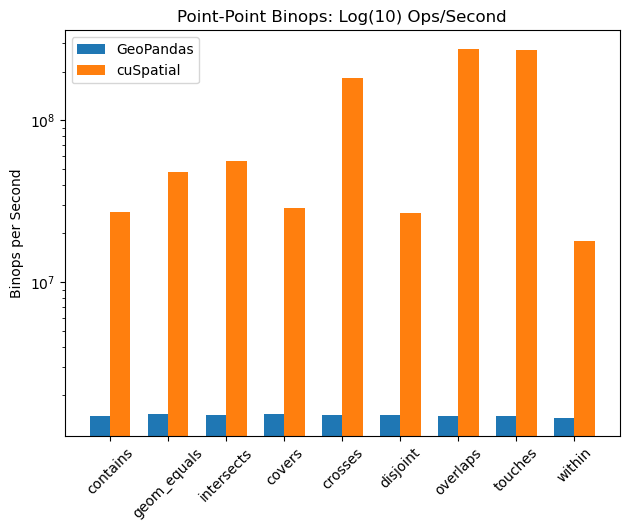

In [91]:
plot_grouped_bars(point_point_results, 'Point-Point Binops: Log(10) Ops/Second')

# Point+LineString Binops Benchmarks

Noteworthy in the Point+LineString benchmark sets are the three predicates with the same execution time as GeoPandas: `contains`, `geom_equals`, and `covers`. This is because these predicates are all impossible, and each library simply terminates immediately returning `False` apparently based on the feature type.

Also noteworthy are `crosses` and `overlaps` which cuSpatial demonstrates a massive performance increase. This is either because our algorithm for determining these predicates is more efficient than GeoPandas, or incorrect.

In [94]:
size = 10_000_000
point_linestring_results = benchmark_dispatch_list(
    point_linestring_dispatch_list,
    size,
    engines,
    predicates
)

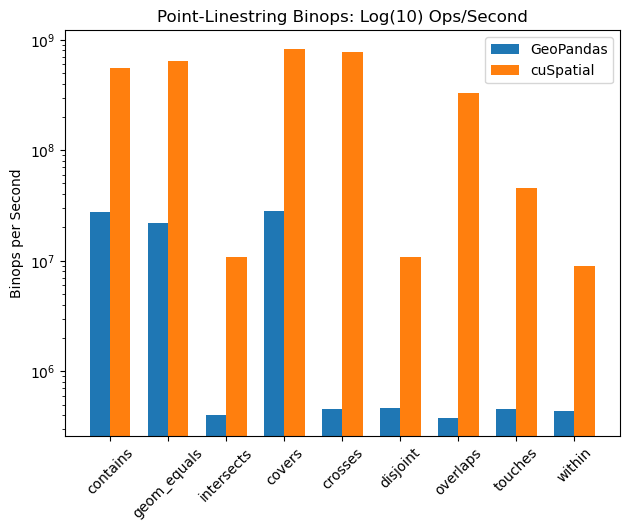

In [95]:
plot_grouped_bars(point_linestring_results, 'Point-Linestring Binops: Log(10) Ops/Second')

# Point-Polygon Benchmarks

Point+Polygon binops produce mixed results. See the graphs and speedup factor listed below.

- `contains`, `geom_equals`, and `covers` have the same result as with Point+LineString: they are impossible, and terminated without a binop.
- `intersection`: Take note of intersection here because Point+Polygon intersection is computed via Point+Polygon `.contains`, which demonstrates the biggest issue with our implementations of point-in-polygon and requires that we develop further optimizations. `quadtree_point_in_polygon` computes the relationship of every point in the rhs with every point in the lhs. The possible result matrix with 10m rows is of course 10mx10m, which cannot fit in memory. In order to use quadtree, the polygons need to have an indexing step to eliminate duplicates at least. `brute_force_point_in_polygon` only supports up to 31 polygons at a time, so handling a dataset of this size would require 10_000_000/31=322580 iterations. Because of these limitations, I have enabled `pairwise_point_in_polygon` to support the basic pairwise implementation of `.contains` as it is represented in GeoPandas. Unfortunately, while it supports the necessary data size, performance is inferior. Performance is inferior as a combination of the unoptimized speed of `pairwise_point_in_polygon` and the expensive indexing techniques designed to support, primarily, `quadtree_point_in_polygon`. The easiest optimization is to handle indexing differently for `pairwise_point_in_polygon`, since expensive and complicated techniques are not required for `Polygon.contains(Point)`. This doesn't solve the issue of indexing for more complicated geometry types. We will see this result repeat itself throughout the benchmarks.
- `disjoint`: Contains an inefficiency based on calling `pairwise_linestring_intersection` that should be removed by the time you read this document in the containing pull request.
- `within`: Within is the inverse of `.intersects` here and suffers from the same performance limitations.

In [96]:
size = 10_000_000
point_polygon_results = benchmark_dispatch_list(
    point_polygon_dispatch_list,
    size,
    engines,
    predicates
)

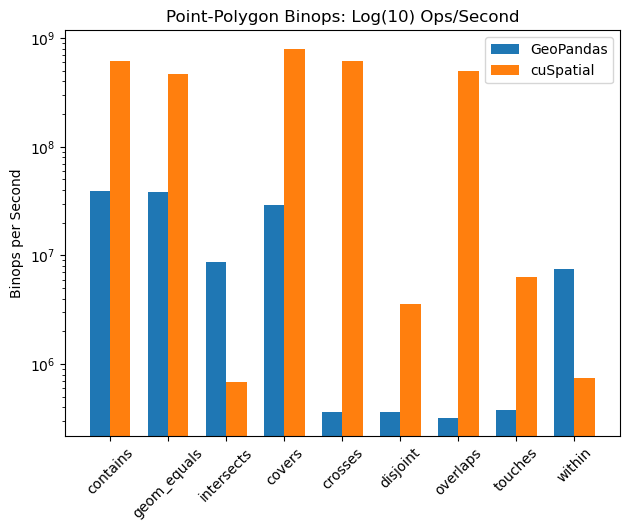

In [98]:
plot_grouped_bars(point_polygon_results, 'Point-Polygon Binops: Log(10) Ops/Second')

# LineString-LineString Benchmarks

LineString results vary but all are largely satisfactory - this is due to the lack of an unoptimized `point_in_polygon` occurring in any of the operations.

In [99]:
size = 10_000_000
linestring_linestring_results = benchmark_dispatch_list(
    linestring_linestring_dispatch_list,
    size,
    engines,
    predicates
)

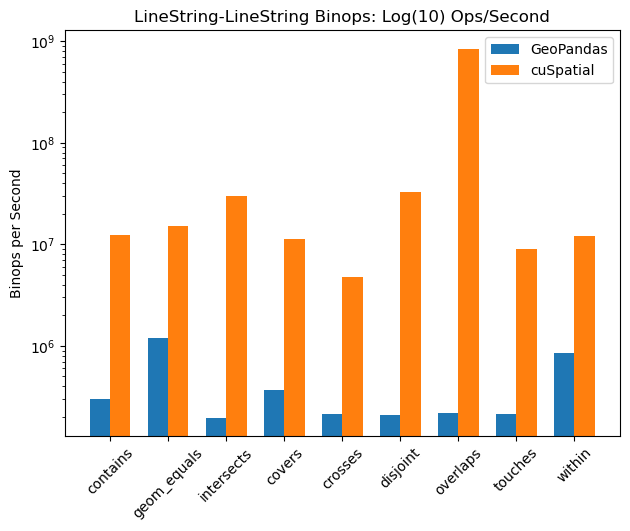

In [100]:
plot_grouped_bars(linestring_linestring_results, 'LineString-LineString Binops: Log(10) Ops/Second')

# LineString-Polygon Benchmarks

- `intersects` and `within` use a combination of intersection and point_in_polygon and the results are unsatisfying. There are likely performance improvements that can be made in the python implementation of intersection which would close the gap, but the underlying problem with `point_in_polygon` remains.

In [107]:
size = 5_000_000
linestring_polygon_results = benchmark_dispatch_list(
    linestring_polygon_dispatch_list,
    size,
    engines,
    predicates
)

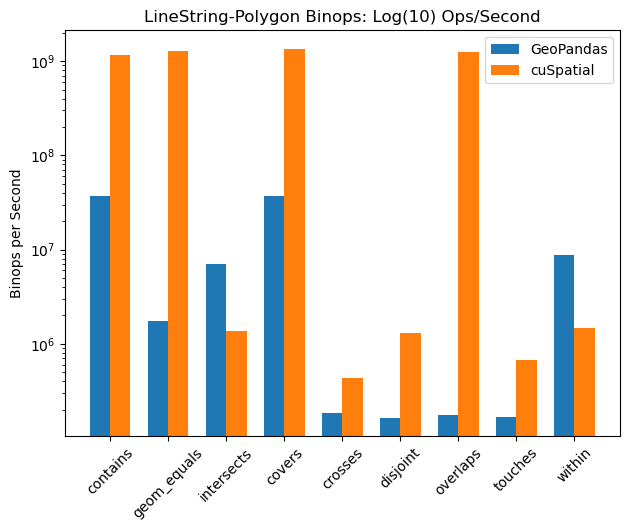

In [102]:
plot_grouped_bars(linestring_polygon_results, 'LineString-Polygon Binops: Log(10) Ops/Second')

# Polygon-Polygon Benchmarks

Performance is better with cuspatial than geopandas for many predicates, but not so much better that it is a really compelling use case. That's with the exception of `crosses` whose comparative performance is so astronomical that it suggests there may be an implementation issue.

In [104]:
size = 5_000_000
polygon_polygon_results = benchmark_dispatch_list(
    polygon_polygon_dispatch_list,
    size,
    engines,
    predicates
)

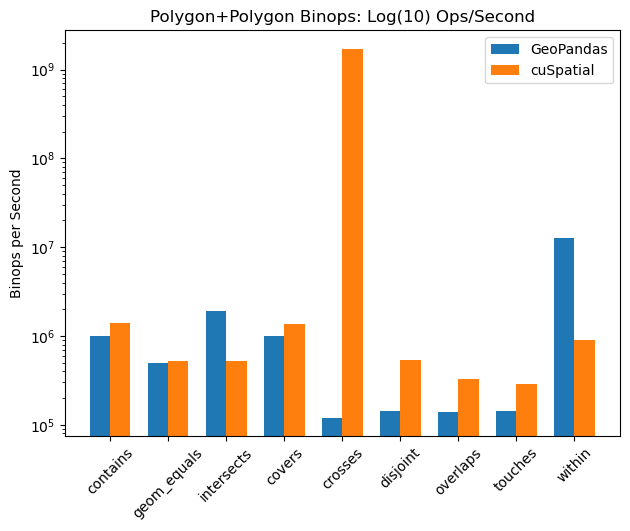

In [106]:
plot_grouped_bars(polygon_polygon_results, 'Polygon+Polygon Binops: Log(10) Ops/Second')